In [70]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.model_selection import KFold
import seaborn as sns
sns.set_theme()
from KSC import KSC

This tutorial shows how to implement the Kernel Synthetic Coupling (KSC) method to impute missing potential outcomes and construct individual confidence intervals around the imputed values. We use the numerical example in Section 3.2 of the paper. 

We first generate $N = 500$ units whose covariates $\{x_i\}_{i = 1}^{N}$ are drawn from the uniform distribution on $[0,1]$. We consider a completely randomized experiment with $N_t = 200$ treated units and $N_c = 300$ control units. The potential outcomes under the control, $\{Y_i(0)\}_{i = 1}^{N}$, are generated from the following data generating process:
$$
Y_i(0) = f_0(x_i) + \epsilon_{0, i},
$$
where $\epsilon_{0, 1}, \ldots, \epsilon_{0, N}$ are independently drawn from $N(0, \sigma_0^2)$ with $\sigma_0 = 1$. Here, $f_0$ is the conditional expectation of $Y_i(0)$ given $x_i$, for which we postulate the following form:
$$
f_0(x) = k(\beta, x) = \exp(-\gamma |x - \beta|^2),
$$
where $k(x, x') = \exp(-\gamma |x - x'|^2)$ for $x, x' \in \mathbb{R}$ is the RBF kernel with $\beta = 0.5$ and $\gamma = 2.5$. Recall that $Y_i(0)$ is observed for the control units, not for the treated units. As in the paper, we mainly focus on how to impute theses missing potential outcomes of the treated units.

In [71]:
# one-dimensional example (d = 1)
# units
N = 500
N_c = int(0.6*N)    # 300 control units
N_t = N - N_c    # 200 treated units

# covariates = uniform from [0, 1]
np.random.seed(0)
X = np.random.random_sample(N)

# sort the covariate values for later visualization
X = np.sort(X)

# complete randomization
id = np.random.permutation(N)
id_t = id[:N_t]
id_c = id[N_t:]
id_t = np.sort(id_t)
id_c = np.sort(id_c)

# covariates of the treated and control units (sorted as well)
X_t = X[id_t]
X_c = X[id_c]

# conditional expectations of potential outcomes
# f_0(x) := E[Y(0) | X = x] = exp(-gamma*|x-0.5|^2)
gamma = 2.5
CE_Y0 = np.exp(-gamma*(X-0.5)**2)

CE_Y0_t = CE_Y0[id_t]
CE_Y0_c = CE_Y0[id_c]


# noise
s = 1.0
eps = s*np.random.randn(N)

# potential outcomes 
Y0 = CE_Y0 + eps

# Y(0) is observed for control units
Y_c = Y0[id_c]

### Step 1: Solving the KSC Problem
We solve the KSC problem, shown in equation (7) of the paper. As we are considering a completely randomized experiment, we set the uniform weights for the constraints of the coupling. Then, the objective function simplifies to equation (6) of the paper, which requires the three kernel matrices $K_{c c} \in \mathbb{R}^{N_c \times N_c}$, $K_{c t} \in \mathbb{R}^{N_c \times N_t}$, and $K_{t t} \in \mathbb{R}^{N_t \times N_t}$, denoting the kernel matrices of the control-control, control-treated, and treated-treated pairs, respectively.

In [72]:
# kernel matrices
K_c = rbf_kernel(X_c[:,np.newaxis], gamma=gamma)  # (N_c, N_c)
K_ct = rbf_kernel(X_c[:,np.newaxis], X_t[:,np.newaxis], gamma=gamma)  # (N_c, N_t)
K_t = rbf_kernel(X_t[:,np.newaxis], gamma=gamma)  # (N_t, N_t)

# lambda
l = 0.01

# KSC
# define the KSC problem
# provide three kernel matrices, lambda, and the weights v, w
# v, w set to uniform weights by default if not provided
# solve the problem by the fixed-point (fp) or gradient descent with KL divergence (gdkl)
# verbose=True to print the iteration information
# method='fp' converges fast for lambda above certain threhold
# method='gdkl' converges for any lambda but can be slow
# for method='gdkl', the step size is (tau_scale * theoretical threshold of Theorem 2 in the paper)
# providing tau_scale > 1.0 (default=1.0) to take a more aggressive step size may speed up method='gdkl'
prob = KSC(Kcc=K_c, Kct=K_ct, Ktt=K_t, l=l) 
pi = prob.solve(method='gdkl', tau_scale=500, verbose=True)

Initialization: objective = 0.033900827483858406
Implement gradient descent with KL divergence
Iteration 1: objective = -0.0601489940286323, objective relative change = -2.7742632995395686, pi change (L1) = 0.4471127600432017
Iteration 2: objective = -0.08064205958310529, objective relative change = -0.34070504229410414, pi change (L1) = 0.18638692457309972
Iteration 3: objective = -0.08870729321496645, objective relative change = -0.10001274364216328, pi change (L1) = 0.11096211013664316
Iteration 4: objective = -0.09286780240134593, objective relative change = -0.04690154592246677, pi change (L1) = 0.07722541141259542
Iteration 5: objective = -0.09534000430102468, objective relative change = -0.026620656845035087, pi change (L1) = 0.05823594581356828
Iteration 6: objective = -0.0969447635298162, objective relative change = -0.016831960943956694, pi change (L1) = 0.04620407796962418
Iteration 7: objective = -0.09805197493765373, objective relative change = -0.011421054294459195, pi ch

Now, we impute the missing potential outcomes of the treated units using the obtained coupling. The following shows the ground truth conditional expectation functions $f_0(x_j)$'s and the imputed values $\hat{Y}_j(0)$'s for the treated units.

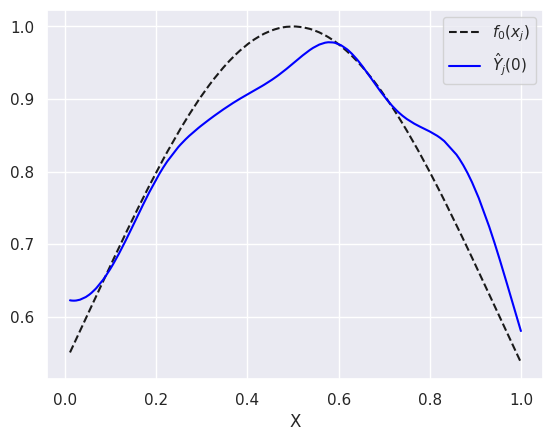

In [73]:
# impute the potential outcomes of treated units
p = N_t * pi
Y_hat_0 = Y_c @ p

plt.plot(X_t, CE_Y0_t, color='k', linestyle='dashed', label=r'$f_0(x_j)$')
plt.plot(X_t, Y_hat_0, color='blue', label=r'$\hat{Y}_j(0)$')
plt.xlabel('X')
plt.legend()
plt.show()

### Step 2: Constructing Individual Confidence Intervals

To construct individual confidence intervals around the imputed values, we estimate $\|f_0\|_{\mathcal{H}} = \sqrt{k(\beta, \beta)} = 1$, where $\mathcal{H}$ is the reproducing kernel Hilbert space (RKHS) associated with $k$ equipped with the norm $\|\cdot\|_{\mathcal{H}}$, and the variance $\sigma_0^2 = 1$ of the variables $\epsilon_{0, i}$'s. To this end, we apply the kernel ridge regression to the control units as discussed in Section 3.2 of the paper. Letting $\widehat{\theta}$ and $\widehat{\sigma}_0$ be the obtained estimates of $\|f_0\|_{\mathcal{H}}$ and $\sigma_0$, respectively, we construct the individual confidence interval $[\widehat{L}_j, \widehat{U}_j]$ for each treated unit, where $\widehat{L}_j$ and $\widehat{U}_j$ are defined as follows:
$$
\begin{align*}
\widehat{L}_j & := \widehat{Y}_j(0) - \widehat{\theta} \cdot \sqrt{\left(K_{t t} + \widehat{P}^\top K_{c c} \widehat{P} - 2 K_{c t}^\top \widehat{P} \right)_{j j}} - z_{1 - \frac{\alpha}{2}} \cdot \widehat{\sigma}_0 \sqrt{\left(\widehat{P}^\top \widehat{P}\right)_{j j}}, \\
\widehat{U}_j & := \widehat{Y}_j(0) + \widehat{\theta} \cdot \sqrt{\left(K_{t t} + \widehat{P}^\top K_{c c} \widehat{P} - 2 K_{c t}^\top \widehat{P} \right)_{j j}} + z_{1 - \frac{\alpha}{2}} \cdot \widehat{\sigma}_0 \sqrt{\left(\widehat{P}^\top \widehat{P}\right)_{j j}},
\end{align*}
$$
where $\widehat{P} = N_t \widehat{\pi}$ for the obtained coupling $\widehat{\pi}$ and $z_{1 - \frac{\alpha}{2}}$ is the $(1 - \frac{\alpha}{2})$-quantile of the standard normal distribution.

In [74]:
# kernel ridge regression (5-fold cross-validation to choose the ridge paramter rho)
np.random.seed(123)
rho_range = np.array([0.001, 0.01, 0.02, 0.03, 0.04, 0.05, 0.1, 1])*N_c

K = 5
err = np.zeros((len(rho_range), K))
sigma_estimates = np.zeros(len(rho_range))
f0_norm_estimates = np.zeros(len(rho_range))

for i, rho in enumerate(rho_range):
    kf = KFold(n_splits=K, shuffle=True)

    for j, (train_index, test_index) in enumerate(kf.split(X_c)):
        X_c_tr = X_c[train_index]
        X_c_test = X_c[test_index]

        Y_c_tr = Y_c[train_index]
        Y_c_test = Y_c[test_index]

        K_c_tr = rbf_kernel(X_c_tr[:,np.newaxis], gamma=gamma)
        N_c_tr = X_c_tr.shape[0]
        alpha_hat_tr = np.linalg.pinv(K_c_tr + np.eye(N_c_tr)*rho) @ Y_c_tr
        K_c_test = rbf_kernel(X_c_test[:,np.newaxis], X_c_tr[:,np.newaxis], gamma=gamma)
        err[i,j] = np.mean((Y_c_test - K_c_test @ alpha_hat_tr)**2)
    
    alpha_hat = np.linalg.pinv(K_c + np.eye(N_c)*rho) @ Y_c
    Y_c_fit = K_c @ alpha_hat
    krr_res = Y_c - Y_c_fit
    sigma_estimates[i] = np.std(krr_res, ddof=0)
    f0_norm_estimates[i] = np.sqrt(np.dot(alpha_hat, Y_c_fit))

rho_id = np.argmin(np.mean(err, axis=1))
rho = rho_range[rho_id] # rho = 12
s_hat = sigma_estimates[rho_id]
f0_norm_hat = f0_norm_estimates[rho_id]


# approximation errors
apprx_err = np.sqrt(np.diag(K_t) + np.diag(p.T @ K_c @ p) - 2.0 * np.diag(p.T @ K_ct))

# Gaussian quantile
alpha = 0.05
q_norm = norm.ppf(1-alpha/2)

p_ss = np.sqrt(np.sum(p**2, axis=0))
variance_term = q_norm * s_hat * p_ss
bias_term = f0_norm_hat * apprx_err

# confidence intervals
L_hat = Y_hat_0 - bias_term - variance_term
U_hat = Y_hat_0 + bias_term + variance_term

Now, we plot the individual confidence intervals $[\widehat{L}_j, \widehat{U}_j]$'s together with the ground truth conditional expectation functions $f_0(x_j)$'s and the imputed values $\hat{Y}_j(0)$'s for the treated units.

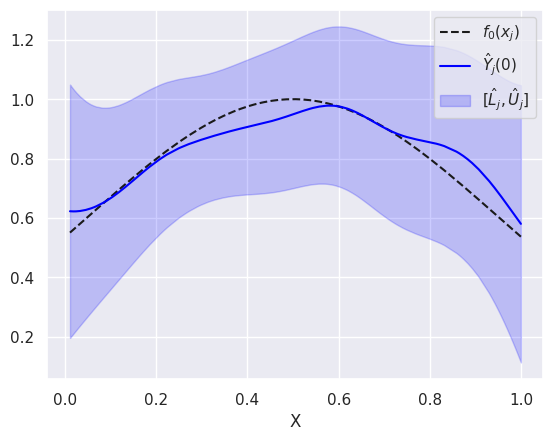

In [75]:
plt.plot(X_t, CE_Y0_t, color='k', linestyle='dashed', label=r'$f_0(x_j)$')
plt.plot(X_t, Y_hat_0, color='blue', label=r'$\hat{Y}_j(0)$')
plt.fill_between(X_t, L_hat, U_hat, color='blue', alpha=0.2, label=r'$[\hat{L}_j, \hat{U}_j]$')
plt.xlabel('X')
plt.legend()
plt.show()